In this project we'll try to build a model that automatically removes the background of any selfie with a person in it, hopefully leaving the person's image intact. For that, we'll use the AISegment.com Matting Human dataset and the U-net neural network.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils import paths
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import *

# 1. Get and visualize the data:

Let's download the dataset from kaggle:

In [ ]:
% cd /content/
# download the dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d laurentmih/aisegmentcom-matting-human-datasets
! mkdir input
! unzip aisegmentcom-matting-human-datasets.zip -d input

We have two folders: /clip_img, which contains the original pictures, and /matting, which contains the masks. Let's see how many images we have:

In [ ]:
clip_img_paths = list(imutils.paths.list_images('/content/input/clip_img'))
print("{} pictures".format(len(clip_img_paths)))
matting_paths = list(imutils.paths.list_images('/content/input/matting'))
print("{} masks".format(len(matting_paths)))

34427 pictures
34426 masks


This is a bit odd because we have one more image in the /clip_img folder, so we'll clean it later. Anyways, we have approximately 34k images, which is very good, especially knowing how difficult it is to label images for this task. Let's see one of them:

In [ ]:
def plot_first_image(paths):
  img = plt.imread(paths[0])

  plt.imshow(img)
  plt.axis(False)
  plt.plot()

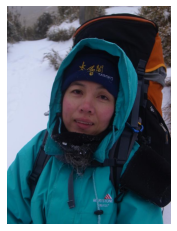

In [ ]:
plot_first_image(clip_img_paths)

We can see that it's a very high quality image, there's only one person and he covers most of the image.

Now let's see one of the masks:

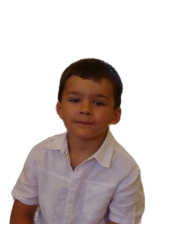

In [ ]:
plot_first_image(matting_paths)

We can see that the background removal of the mask is very good in this case.

Let's build a function that, given the path of a photo, returns the path of its respective mask:

In [ ]:
def get_matting_path(clip_path):
  folder_id = clip_path.split('_')[-1].split(os.path.sep)[0]
  id = os.path.sep.join(clip_path.split(os.path.sep)[6:]).split('.')[0]
  big_folder_id = id.split("-")[0]
  matting_path = os.path.join('/content/input/matting', big_folder_id, 'matting_{}'.format(folder_id), "{}.png".format(id))

  return matting_path

Now let's keep only the images that have a mask associated:

In [ ]:
clip_img_paths = [clip_path for clip_path in clip_img_paths if get_matting_path(clip_path) in matting_paths]

In [ ]:
len(clip_img_paths)

34426

We can see that we only deleted one picture. Let's plot a picture along with its mask:

In [ ]:
def plot_clip_and_matting(clip_path):
  matting_path=get_matting_path(clip_path)

  clip = plt.imread(clip_path)
  mat = plt.imread(matting_path)

  fig = plt.figure(figsize=(12,7))
  grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=1)

  grid[0].imshow(clip)
  grid[0].axis(False)

  grid[1].imshow(mat)
  grid[1].axis(False)

  plt.show()

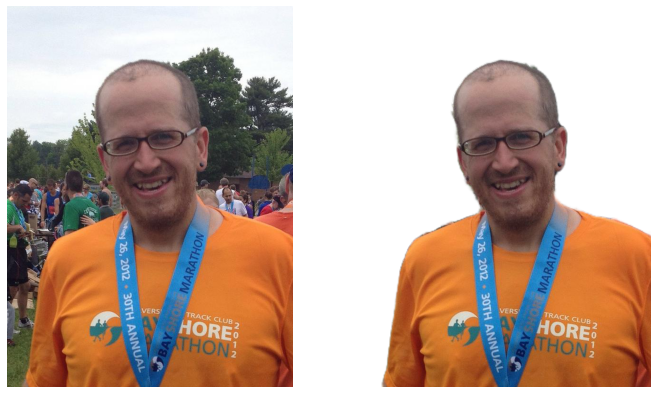

In [ ]:
path = clip_img_paths[3]

plot_clip_and_matting(path)

**Please note that the mask is not perfect. Since we'll use the masks as labels for our model, it would be unfair to expect that our model performed flawlessly if the labels have mistakes** (it's obviously very difficult to manually label the images without mistakes).

Each masks includes an alpha channel, i.e. a channels that tells us how transparent is a given pixel. In this situation, we can interpret it as the likelihood of a given pixel to be included in a person's image. Let's plot it:

Shape of the mask: (800, 600, 4)


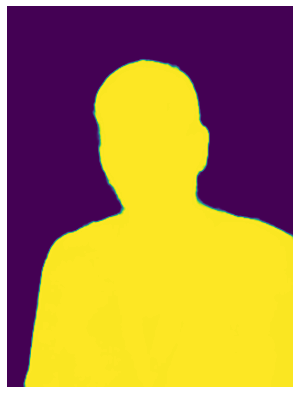

In [ ]:
path = clip_img_paths[3]

mat_img = cv2.imread(get_matting_path(path), cv2.IMREAD_UNCHANGED)

# we can see that our masks have 4 color channels, RGB + alpha = RGBA
print("Shape of the mask: {}".format(mat_img.shape))

alpha = mat_img[:,:,3]

fig = plt.figure(figsize=(12,7))
plt.imshow(alpha)
plt.axis(False)

plt.show()

In [ ]:
alpha

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 253, 253, 252],
       [  0,   0,   0, ..., 253, 252, 252],
       [  0,   0,   0, ..., 253, 252, 252]], dtype=uint8)

We can see that our alpha channel takes values between 0 and 255 (as the rest of the color channels), where 255 means absolute opacity and 0 means absolute transparence.

# 2. Preprocessing:

Let's split the paths. Since we have a lot of images, we'll only use a 5% for testing, and a 9.5% for validation:

In [ ]:
train_paths, test_paths = train_test_split(clip_img_paths, test_size=0.05, random_state=42)
train_paths, val_paths = train_test_split(train_paths, test_size=0.1, random_state=42)

Let's build a function that, given a picture's path, returns us its alpha channel:

In [ ]:
def get_target(clip_path, target_size):
    matting_path = get_matting_path(clip_path)
    matting_image = load_img(matting_path, target_size=(target_size[0],target_size[1],4), color_mode="rgba")
    matting_image = img_to_array(matting_image)
    alpha_channel = matting_image[:,:,3]
    
    return alpha_channel

Let's define the preprocessing steps:

In [ ]:
def preprocessor(clip_path):
    
    # the input size of U-net is (572,572,3)
    image = load_img(clip_path, target_size=(572,572,3))
    image = img_to_array(image) / 255
    
    # the output size of U-net is (388,388,3)
    target = get_target(clip_path, target_size=(388,388,3)) / 255
    target = np.expand_dims(target, axis=-1)
    
    return (image, target)

Since the images don't fit in memory, and we can't use the flow_from_directory method (because it uses the names of the directories as labels), we'll define our own generator. We'll use a batch size of 8 because the images are so large that bigger batches don't fit in memory.

In [ ]:
def training_generator(path_split, batch_size=8):
    while True:
        for i in range(len(path_split) // batch_size):

            clip_paths = path_split[batch_size*i:batch_size*(i+1)]
            preprocessed_pairs = [preprocessor(clip_path) for clip_path in clip_paths]
            images = [pair[0] for pair in preprocessed_pairs] 
            targets = [pair[1] for pair in preprocessed_pairs] 

            images = np.array(images) 
            targets = np.array(targets) 
            
            yield(images, targets)

Let's instantiate our generators and do a sanity check:

In [ ]:
train_gen = training_generator(train_paths)

val_gen = training_generator(val_paths)

print("Shape of the inputs: {}".format(next(train_gen)[0].shape))
print("Shape of the targets: {}".format(next(train_gen)[1].shape))

Shape of the inputs: (8, 572, 572, 3)
Shape of the targets: (8, 388, 388, 1)


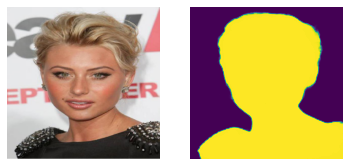

In [ ]:
images, masks = next(train_gen)
image = array_to_img(images[0])
mask = array_to_img(masks[0])

plt.subplot(121)
plt.imshow(image)
plt.axis(False)

plt.subplot(122)
plt.imshow(mask)
plt.axis(False)


plt.show()

They seem to work fine, so let's reinitialize them:

In [ ]:
train_gen = training_generator(train_paths)

val_gen = training_generator(val_paths)

# 3. Model Selection:

Next, we'll define the original U-net architecture:


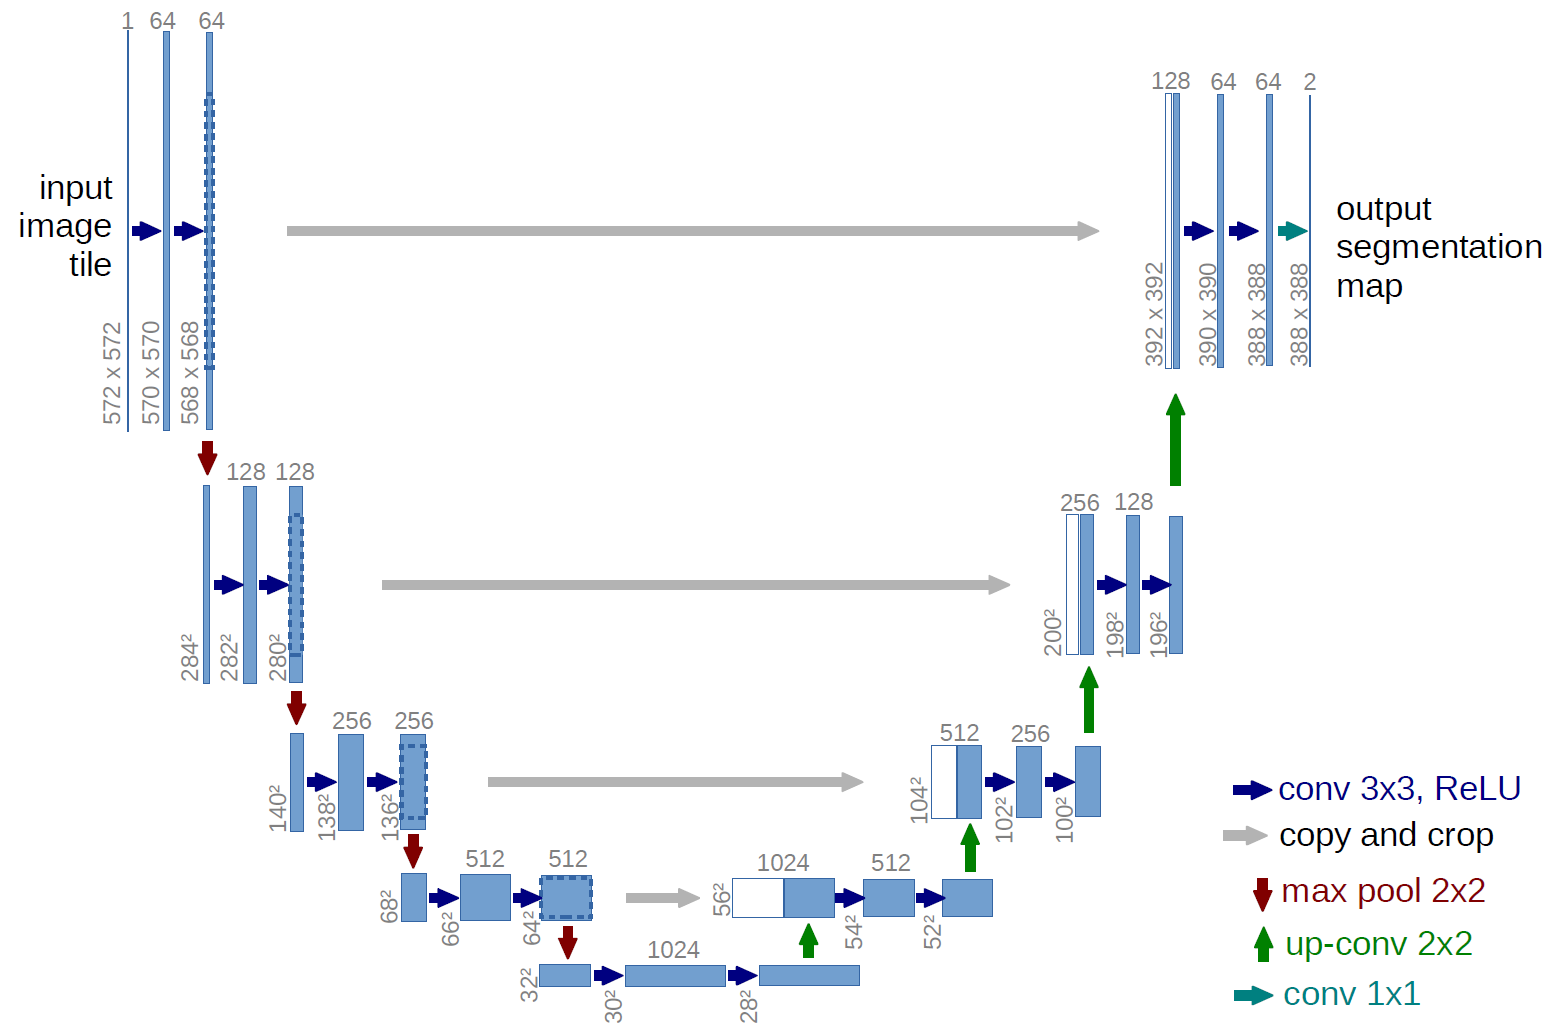

This architecture seems to work very successfully in medical problems. The way it's built is basically the following: 

At the downsampling path, some convolutional and max pooling layers try to figure out what objects are approximately where (this task corresponds to the first sets of convolutional and max pooling layers), which results in a set of channels of very low resolution. This is mostly because these first layers use valid padding and max pooling filters, which end up downsampling a lot the image.

The rest of the layers try to upsample the image (i.e. to increase its resolution) while understanding as accurately as possible which pixel belongs to the object we are trying to segment. This is achieved via transposed convolution, which is an upsampling technique, and via concatenating the features of the downsampling path with the outputs of the transposed convolution.

The result is a segmentation map, which gets compared with the target (the true segmentation map), and the error is backpropagated.

Let's build the model:

In [ ]:
chan_dim = -1

# check if we're using "channels first": 
if K.image_data_format() == "channels_first":
  input_shape = (depth, height, width)
  chan_dim = 1

class original_Unet:
  @staticmethod
    
  def conv_module(x, K):
    x = Conv2D(K, (3,3), padding="valid", activation="relu")(x)
    x = Conv2D(K, (3,3), padding="valid", activation="relu")(x)

    return x
  
  def conv_upconv_module(x, K):
    x = Conv2D(K, (3,3), padding="valid", activation="relu")(x)
    x = Conv2D(K, (3,3), padding="valid", activation="relu")(x)
    x = Conv2DTranspose(K/2, (2,2), strides=(2, 2), padding='valid')(x)

    return x

  def build(input_shape):

    input = Input(shape=input_shape)

    c1 = original_Unet.conv_module(input, 64)
    p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(c1)
    
    c2 = original_Unet.conv_module(p1, 128)
    p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(c2)

    c3 = original_Unet.conv_module(p2, 256)
    p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(c3)

    c4 = original_Unet.conv_module(p3, 512)
    p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(c4)

    u6 = original_Unet.conv_upconv_module(p4, 1024)
    c4 = Cropping2D(cropping=((4,4),(4,4)))(c4)
    u6 = concatenate([u6, c4], axis=chan_dim)

    u7 = original_Unet.conv_upconv_module(u6, 512)
    c3 = Cropping2D(cropping=((16,16), (16,16)))(c3)
    u7 = concatenate([u7, c3], axis=chan_dim)

    u8 = original_Unet.conv_upconv_module(u7, 256)
    c2 = Cropping2D(cropping=((40,40), (40,40)))(c2)
    u8 = concatenate([u8, c2], axis=chan_dim)

    u9 = original_Unet.conv_upconv_module(u8, 128)
    c1 = Cropping2D(cropping=((88,88), (88,88)))(c1)
    u9 = concatenate([u9, c1], axis=chan_dim)

    c9 = Conv2D(64, (3,3), padding="valid", activation="relu")(u9)
    c9 = Conv2D(64, (3,3), padding="valid", activation="relu")(c9)
    output = Conv2D(1, (1, 1), padding="valid", activation='sigmoid')(c9)

    model = Model(inputs=input, outputs=output)

    return model

Let's plot it so we can check if we built it correctly:

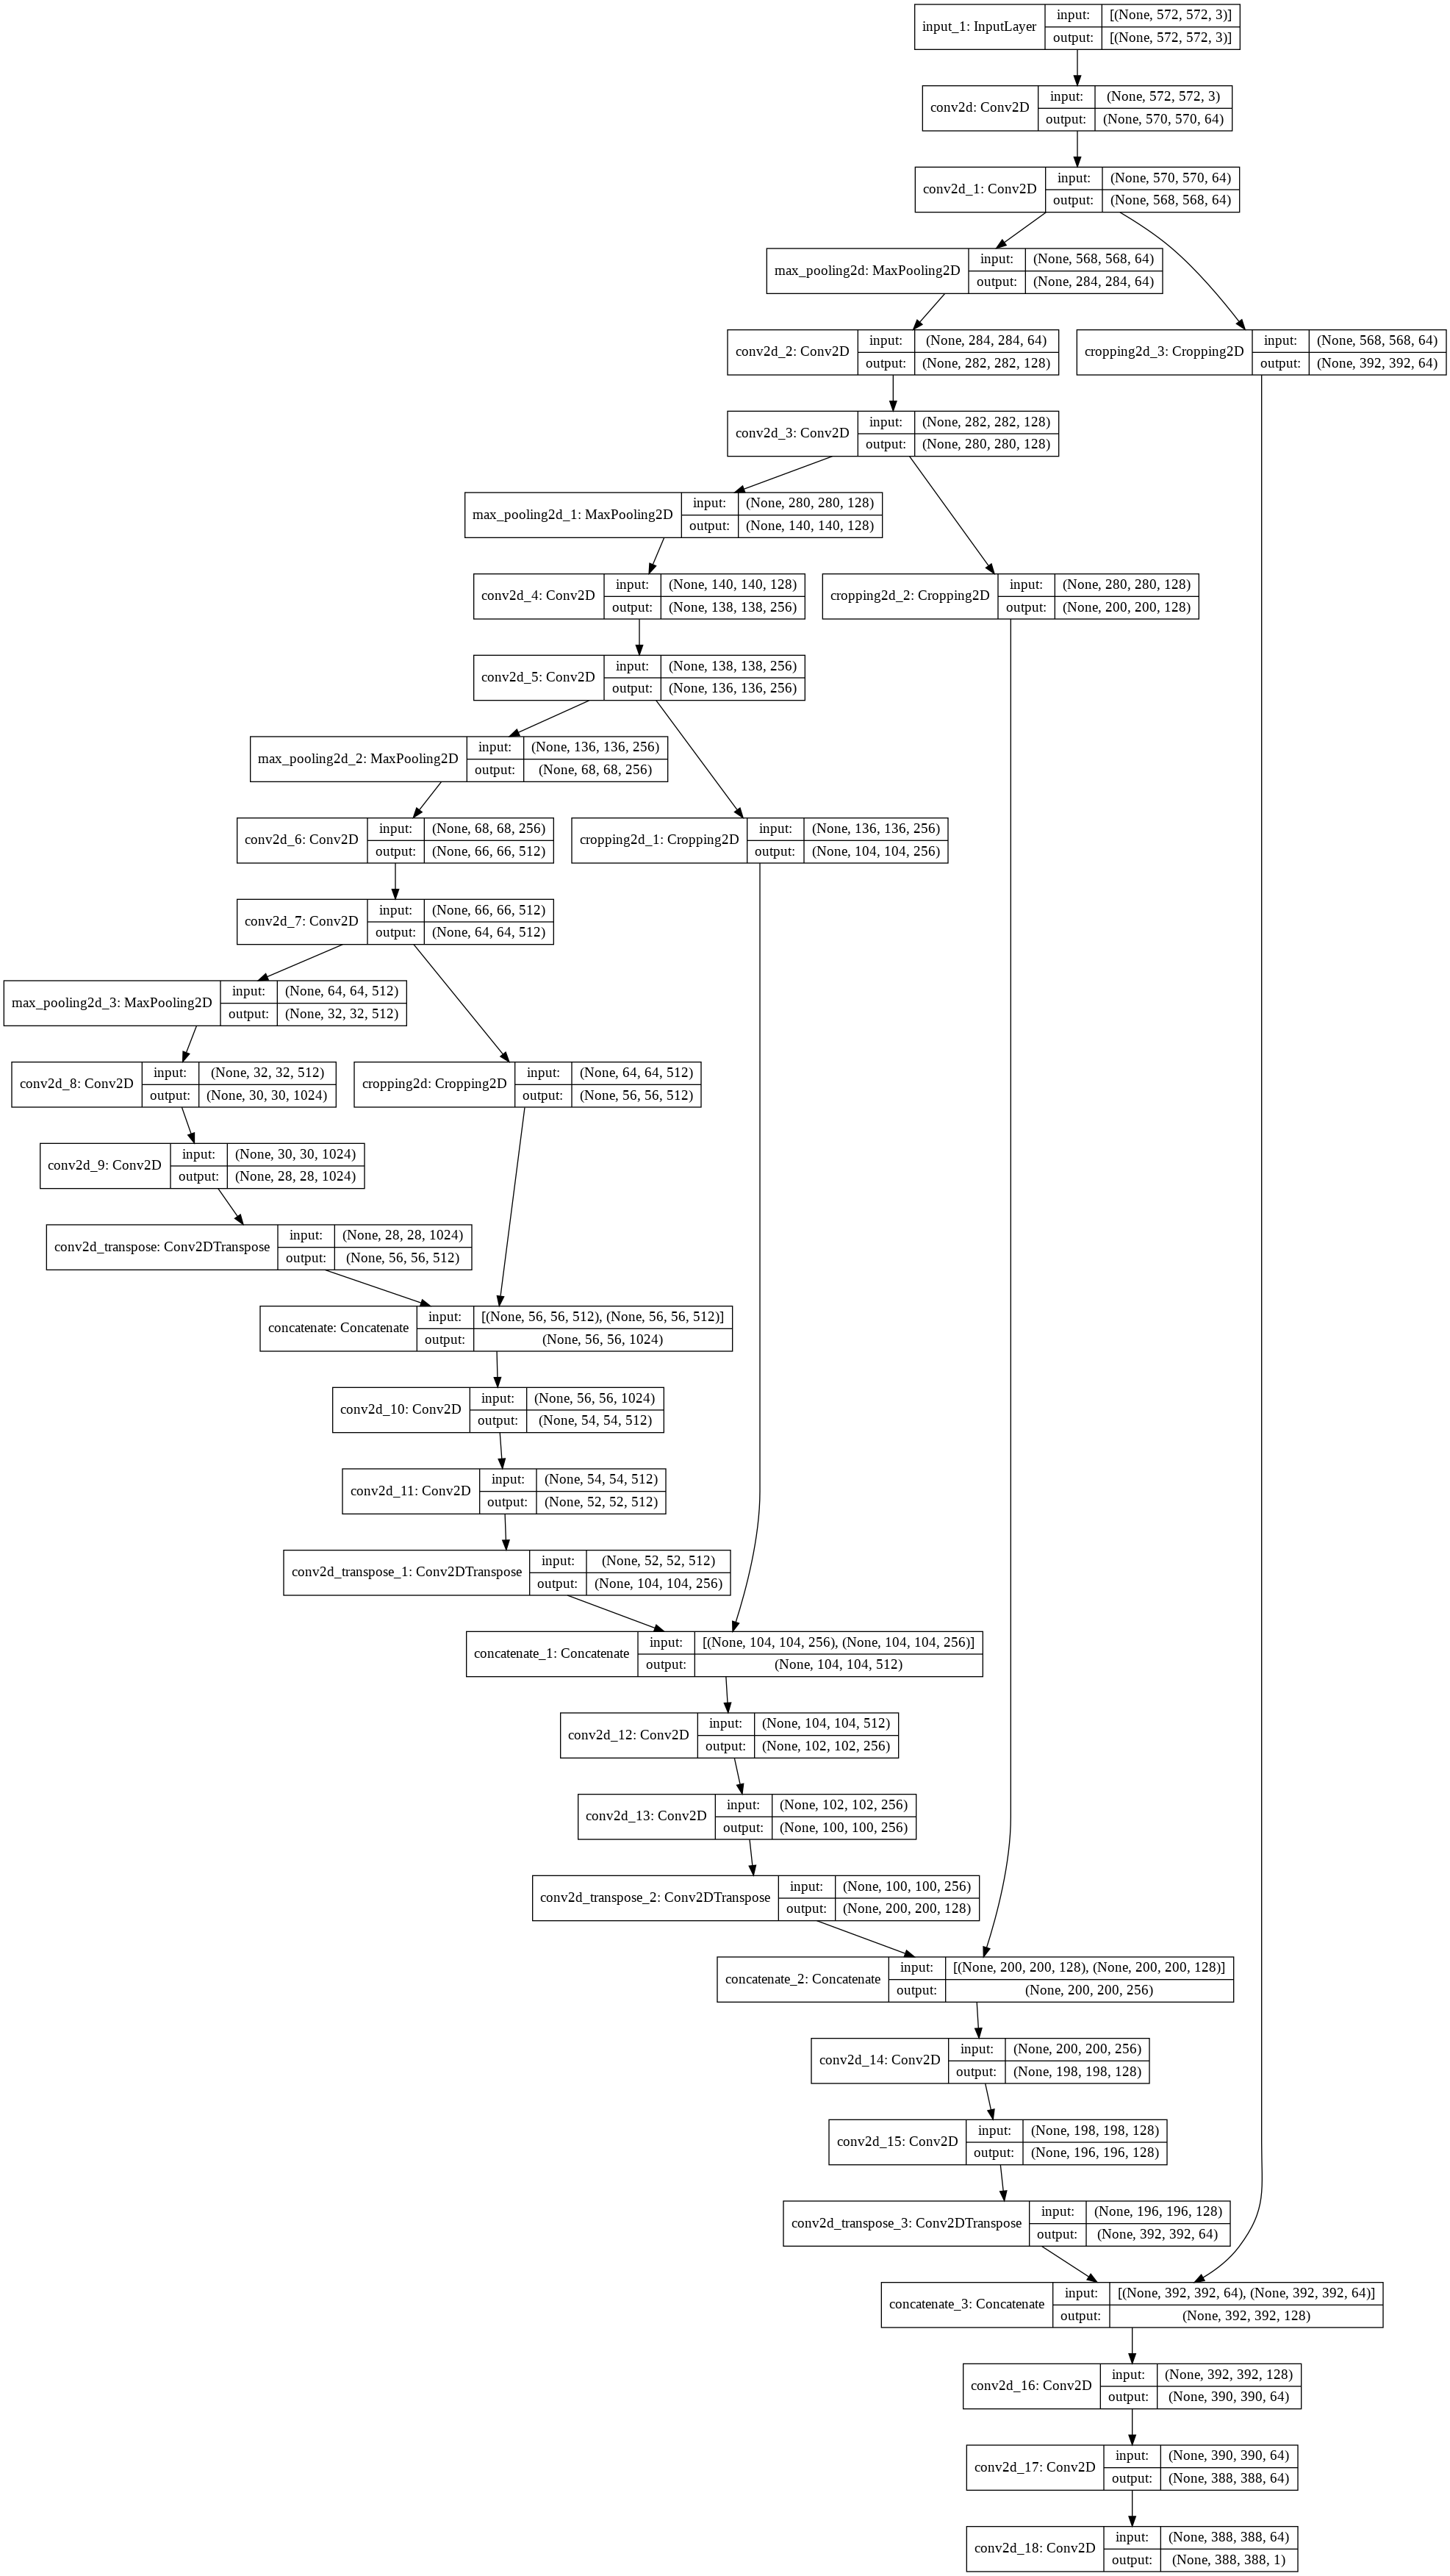

In [ ]:
orig_unet = original_Unet.build(input_shape=(572,572,3))
plot_model(orig_unet, show_shapes=True)

Everything looks fine, let's compile and train it:

In [ ]:
orig_unet.compile(optimizer='adam', loss="binary_crossentropy")

In [ ]:
H = orig_unet.fit(train_gen, steps_per_epoch=len(train_paths)//8, validation_data=val_gen,
             validation_steps=len(val_paths)//8, epochs=2)

Epoch 1/2
3679/3679 [==============================] - 2821s 767ms/step - loss: 0.7799 - val_loss: 0.6901
Epoch 2/2
1782/3679 [=============>................] - ETA: 22:36 - loss: 0.6902

Well, it didn't improve as fast as expected. This is probably for multiple reasons: first of all, to match the dimension of the Concatenate layers, the author crops some of the inputs, which may work well for medical images, but in this situation doesn't seem to work so well. It's also very slow to train because the input size is very large, and the input and output images don't have the same shape, which may be detrimental to the performance. 

I will build a very similar model, only much simpler and without any of these problems. For that, I will use "same" padding, so we don't have to crop the inputs to the Concatenate layers, and the input and the output have the same size.

Since the labels are not perfect, we want our model to be less complex so it can generalize as much as possible, and it doesn't reproduce the mistakes made in the labels. For that, I will also use smaller images and less filters (which will also reduce the training time) and some Dropout.

In [ ]:
chan_dim = -1

if K.image_data_format() == "channels_first":
  input_shape = (depth, height, width)
  chan_dim = 1

class Unet:
  @staticmethod

  def conv_module(x, K):
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)

    return x
  
  def conv_upconv_module(x, K):
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Conv2DTranspose(K/2, (2,2), strides=(2, 2), padding='same')(x)

    return x

  def build(input_shape):

    input = Input(shape=input_shape)

    c1 = Unet.conv_module(input, 16)
    p1 = MaxPooling2D(pool_size=(2,2))(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = Unet.conv_module(p1, 32)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Unet.conv_module(p2, 64)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = Unet.conv_module(p3, 128)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
    p4 = Dropout(0.1)(p4)

    u6 = Unet.conv_upconv_module(p4, 256)
    u6 = concatenate([u6, c4], axis=chan_dim)

    u7 = Unet.conv_upconv_module(u6, 128)
    u7 = concatenate([u7, c3], axis=chan_dim)

    u8 = Unet.conv_upconv_module(u7, 64)
    u8 = concatenate([u8, c2], axis=chan_dim)

    u9 = Unet.conv_upconv_module(u8, 32)
    u9 = concatenate([u9, c1], axis=chan_dim)

    c9 = Conv2D(16, (3,3), padding="same", activation="relu")(u9)
    c9 = Conv2D(16, (3,3), padding="same", activation="relu")(c9)
    c9 = Dropout(0.1)(c9)
    output = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(c9)

    model = Model(inputs=input, outputs=output)

    return model

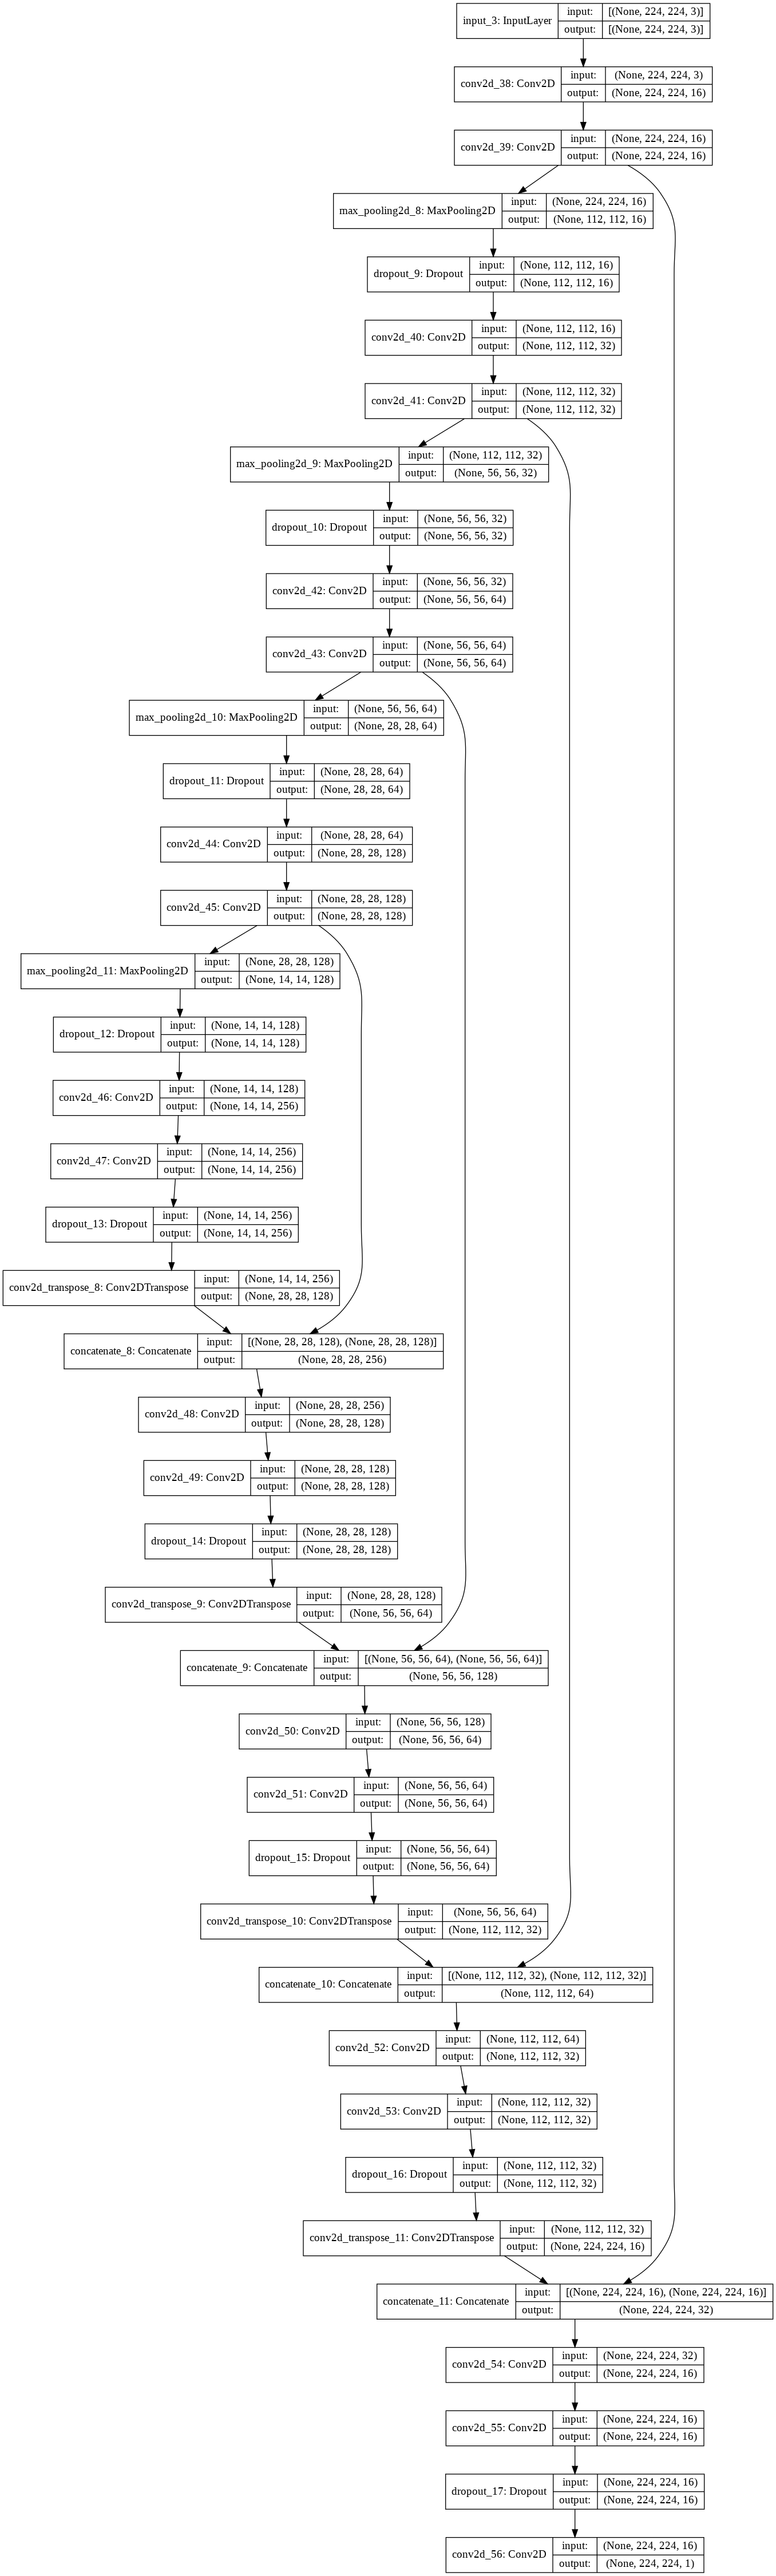

In [ ]:
unet = Unet.build(input_shape=(224,224,3))
plot_model(unet, show_shapes=True)

Let's build the preprocessors and generators for this model:

In [ ]:
def preprocessor(clip_path):
    image = load_img(clip_path, target_size=(224,224,3))
    image = img_to_array(image) / 255.0
    
    target = get_target(clip_path, target_size=(224,224,4)) / 255.0
    target = np.expand_dims(target, axis=-1)
    
    return (image, target)

In [ ]:
def training_generator(path_split, batch_size=128):
    while True:
        for i in range(len(path_split) // batch_size):

            clip_paths = path_split[batch_size*i:batch_size*(i+1)]
            preprocessed_pairs = [preprocessor(clip_path) for clip_path in clip_paths]
            images = [pair[0] for pair in preprocessed_pairs] 
            targets = [pair[1] for pair in preprocessed_pairs] 

            images = np.array(images) 
            targets = np.array(targets) 
            
            yield(images, targets)

We will use very slight data augmentation so that the model doesn't see very distorted images, which would be unlikely to generalize well to normal images. 

As I said before, since in this case the labels are not perfect, we really want our model to be able to generalize as much as possible, and obviously data augmentation will help it do that.

Let's see how our images and labels will look after data augmentation:

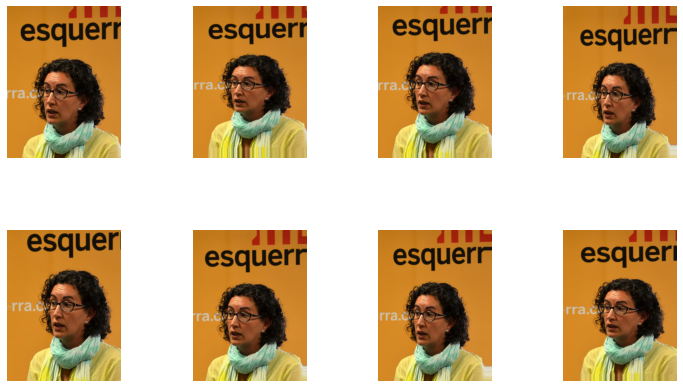

In [ ]:
aug = ImageDataGenerator(rotation_range=0.1, width_shift_range=0.05, height_shift_range=0.05,
                         zoom_range=0.1)
path = clip_img_paths[1]
image = img_to_array(load_img(path, (331,331,3)))
fig = plt.figure(figsize=(12,7))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=1)
for i in range(8):
    transformed_image = aug.random_transform(image)
    grid[i].imshow(array_to_img(transformed_image))
    grid[i].axis(False)
plt.show()

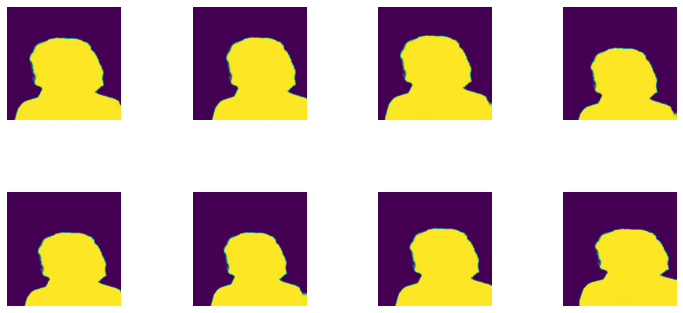

In [ ]:
target = get_target(path, (331,331,3))
fig = plt.figure(figsize=(12,7))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=1)
for i in range(8):
    transformed_target = aug.random_transform(np.expand_dims(target, axis=-1))
    grid[i].imshow(array_to_img(transformed_target))
    grid[i].axis(False)
plt.show()

We can see that the data augmentation is very slight, which will avoid that our model sees very unnatural images.

Let's define the preprocessor and the generator:

In [ ]:
def aug_preprocessor(clip_path, target_size=(224,224,3)):
    image = load_img(clip_path, target_size=target_size)
    image = img_to_array(image)
    
    target = get_target(clip_path, target_size)
    
    full_img = np.zeros((target_size[0],target_size[1],4))
    full_img[:,:,:3] = image
    full_img[:,:,3] = target
    
    transformed_full_image = aug.random_transform(full_img)
    transformed_image = array_to_img(transformed_full_image[:,:,:3]) / 255.0
    transformed_target = array_to_img(np.expand_dims(transformed_full_image[:,:,3], axis=-1)) / 255.0
    
    return (img_to_array(transformed_image), img_to_array(transformed_target))

In [ ]:
def aug_training_generator(path_split, batch_size=128):
    while True:
        for i in range(len(path_split) // batch_size):

            clip_paths = path_split[batch_size*i:batch_size*(i+1)]
            preprocessed_pairs = [aug_preprocessor(clip_path) for clip_path in clip_paths]
            images = [pair[0] for pair in preprocessed_pairs] 
            targets = [pair[1] for pair in preprocessed_pairs] 

            images = np.array(images) 
            targets = np.array(targets) 
            
            yield(images, targets)

In [ ]:
train_gen = aug_training_generator(train_paths, batch_size=128)

val_gen = training_generator(val_paths, batch_size=128)

In [ ]:
unet.compile(optimizer='adam', loss="binary_crossentropy")

In [ ]:
H = unet.fit(train_gen, steps_per_epoch=len(train_paths)//128, validation_data=val_gen,
             validation_steps=len(val_paths)//128, epochs=2)

Epoch 1/2
229/229 [==============================] - 2006s 9s/step - loss: 0.3495 - val_loss: 0.1467
Epoch 2/2
229/229 [==============================] - 2096s 9s/step - loss: 0.1267 - val_loss: 0.0907


This works definitely much better than the original model. But I think that adding batch normalization layers will speed up training a lot, so let's try it:

In [ ]:
chan_dim = -1

if K.image_data_format() == "channels_first":
  input_shape = (depth, height, width)
  chan_dim = 1

class Unet:
  @staticmethod

  def conv_module(x, K):
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)

    return x
  
  def conv_upconv_module(x, K):
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = Conv2D(K, (3,3), padding="same", activation="relu")(x)
    x = BatchNormalization(axis=chan_dim)(x)
    x = Dropout(0.2)(x)
    x = Conv2DTranspose(K/2, (2,2), strides=(2, 2), padding='same')(x)

    return x

  def build(input_shape):

    input = Input(shape=input_shape)

    c1 = BatchNormalization(axis=chan_dim)(input)
    c1 = Unet.conv_module(c1, 16)
    p1 = MaxPooling2D(pool_size=(2,2))(c1)
    p1 = Dropout(0.2)(p1)
    
    c2 = Unet.conv_module(p1, 32)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)
    p2 = Dropout(0.2)(p2)

    c3 = Unet.conv_module(p2, 64)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Unet.conv_module(p3, 128)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
    p4 = Dropout(0.2)(p4)

    u6 = Unet.conv_upconv_module(p4, 256)
    u6 = concatenate([u6, c4], axis=chan_dim)

    u7 = Unet.conv_upconv_module(u6, 128)
    u7 = concatenate([u7, c3], axis=chan_dim)

    u8 = Unet.conv_upconv_module(u7, 64)
    u8 = concatenate([u8, c2], axis=chan_dim)

    u9 = Unet.conv_upconv_module(u8, 32)
    u9 = concatenate([u9, c1], axis=chan_dim)

    c9 = Conv2D(16, (3,3), padding="same", activation="relu")(u9)
    c9 = BatchNormalization(axis=chan_dim)(c9)
    c9 = Conv2D(16, (3,3), padding="same", activation="relu")(c9)
    c9 = BatchNormalization(axis=chan_dim)(c9)
    c9 = Dropout(0.2)(c9)
    output = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(c9)

    model = Model(inputs=input, outputs=output)

    return model

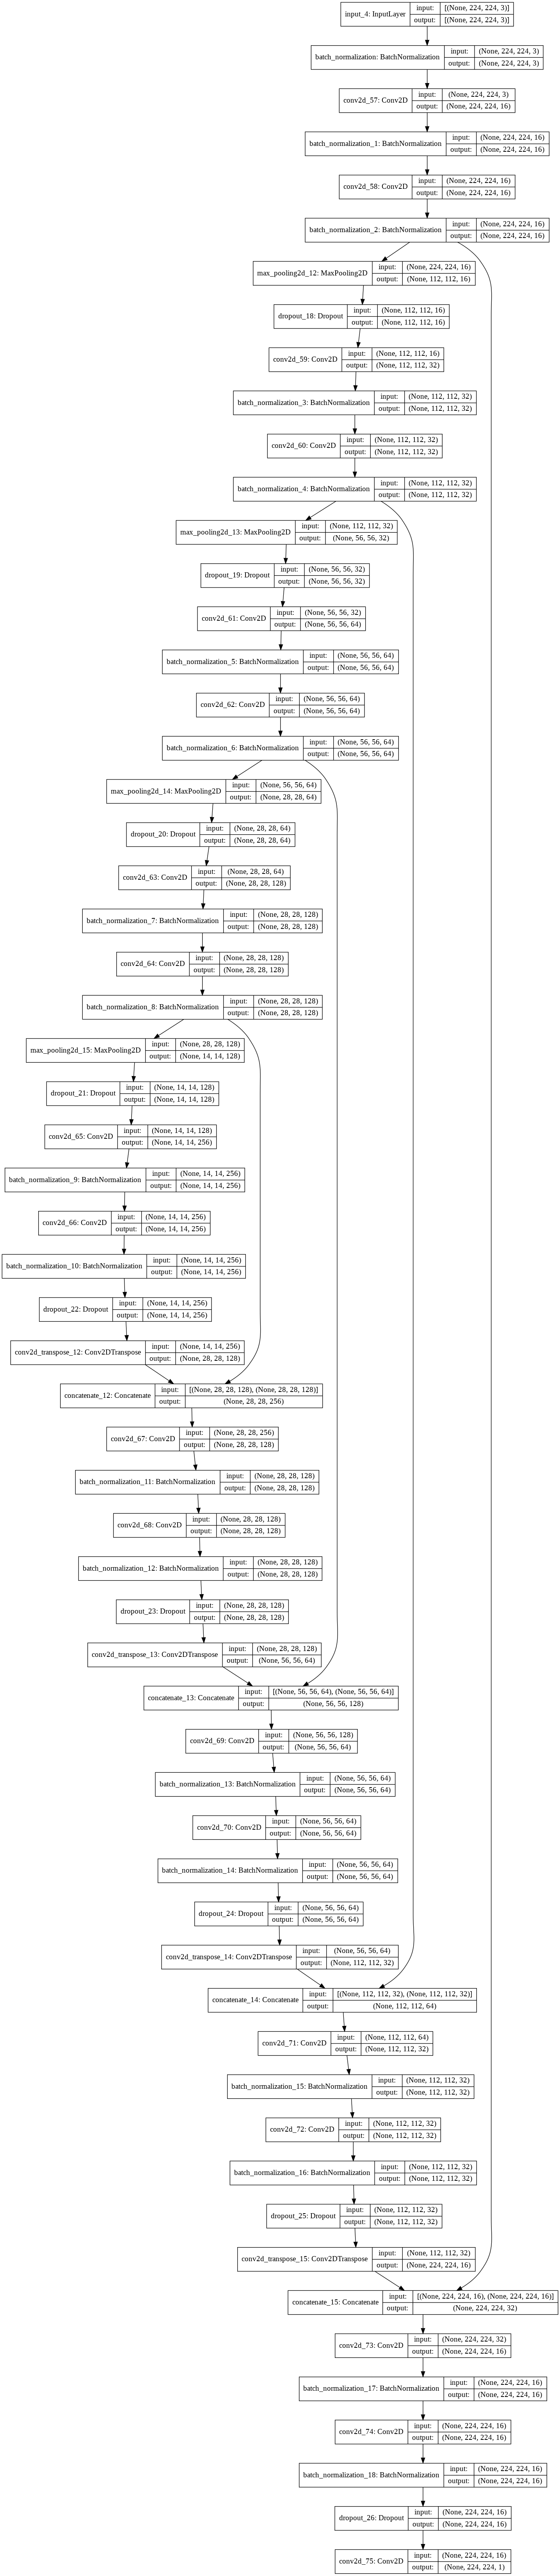

In [ ]:
unet = Unet.build(input_shape=(224,224,3))
plot_model(unet, show_shapes=True)

Let's reinitialize the generators:

In [ ]:
train_gen = aug_training_generator(train_paths, batch_size=128)

val_gen = training_generator(val_paths, batch_size=128)

Since it will take very long let's use a checkpoint callback:

In [ ]:
checkpoint = ModelCheckpoint("unet_final.h5", save_best_only=True)
callbacks = [checkpoint]

In [ ]:
unet.compile(optimizer='adam', loss="binary_crossentropy")

Let's train it:

In [ ]:
H = unet.fit(train_gen, steps_per_epoch=len(train_paths)//128, validation_data=val_gen,
             validation_steps=len(val_paths)//128, epochs=9, callbacks=callbacks)

Epoch 1/9
229/229 [==============================] - 1647s 7s/step - loss: 0.1822 - val_loss: 1.1815
Epoch 2/9
229/229 [==============================] - 1503s 7s/step - loss: 0.0808 - val_loss: 0.0895
Epoch 3/9
229/229 [==============================] - 1491s 7s/step - loss: 0.0619 - val_loss: 0.0616
Epoch 4/9
229/229 [==============================] - 1704s 7s/step - loss: 0.0525 - val_loss: 0.0531
Epoch 5/9
229/229 [==============================] - 1586s 7s/step - loss: 0.0470 - val_loss: 0.0469
Epoch 6/9
229/229 [==============================] - 1535s 7s/step - loss: 0.0430 - val_loss: 0.0482
Epoch 7/9
229/229 [==============================] - 1645s 7s/step - loss: 0.0403 - val_loss: 0.0426
Epoch 8/9
229/229 [==============================] - 1478s 6s/step - loss: 0.0377 - val_loss: 0.0406
Epoch 9/9
229/229 [==============================] - 1478s 6s/step - loss: 0.0361 - val_loss: 0.0415


We can see that it clearly improved much faster than the models trained before. I trained it for 9 epochs because at epoch 9 it already started to overfit. Since I was using a checkpoint with save_best_only=True, I was able to revert it back to the best performing model on the validation set.

# 4. Results:

Let's load our model and see how it performs in the test images:

In [ ]:
unet = load_model('/content/trained_unet.h5')

Let's see one example:

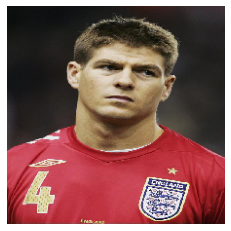

In [ ]:
test_path = test_paths[1]
image = load_img(test_path, target_size=(224,224,3))
plt.imshow(image)
plt.axis(False)
plt.show()

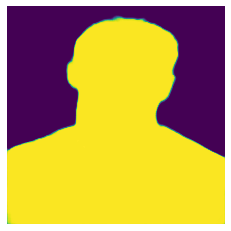

In [ ]:
def get_predictions(img_path):
  image = load_img(img_path, target_size=(224,224,3))
  image = np.expand_dims(img_to_array(image), axis=0) / 255
  pred = unet.predict(image)[0]

  return pred

prediction = get_predictions(test_path)
prediction = array_to_img(prediction)
plt.imshow(prediction)
plt.axis(False)
plt.show()

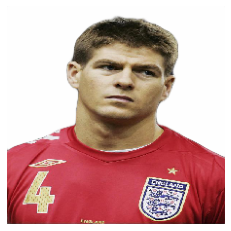

In [ ]:
def remove_background(img_path):
  pred = get_predictions(img_path)
  image = load_img(img_path, target_size=(224,224,3))
  image = img_to_array(image)
  mask = (image-255)*pred
  
  return mask

mask = remove_background(test_path)
mask = array_to_img(mask)
plt.imshow(mask)
plt.axis(False)
plt.show()

Not so bad! Let's see some more results:

In [ ]:
def plot_results(n_images):
  fig = plt.figure(figsize=(15,7*n_images))
  grid = ImageGrid(fig, 111, nrows_ncols=(n_images, 3), axes_pad=1)

  index_list = np.random.choice(len(test_paths), size=n_images, replace=False)

  for i, index in enumerate(index_list):
    test_path = test_paths[index]
    image = load_img(test_path, target_size=(224,224,3))
    grid[3*i].imshow(image)
    grid[3*i].axis(False)

    target_path = get_matting_path(test_path)
    target = load_img(target_path, target_size=(224,224,3), color_mode="rgba")
    grid[3*i+1].imshow(target)
    grid[3*i+1].axis(False)

    prediction = remove_background(test_path)
    prediction = array_to_img(prediction)
    grid[3*i+2].imshow(prediction)
    grid[3*i+2].axis(False)

    if i==0:
      grid[3*i].set_title("Images")
      grid[3*i+1].set_title("Targets")
      grid[3*i+2].set_title("Predictions")

  plt.show()

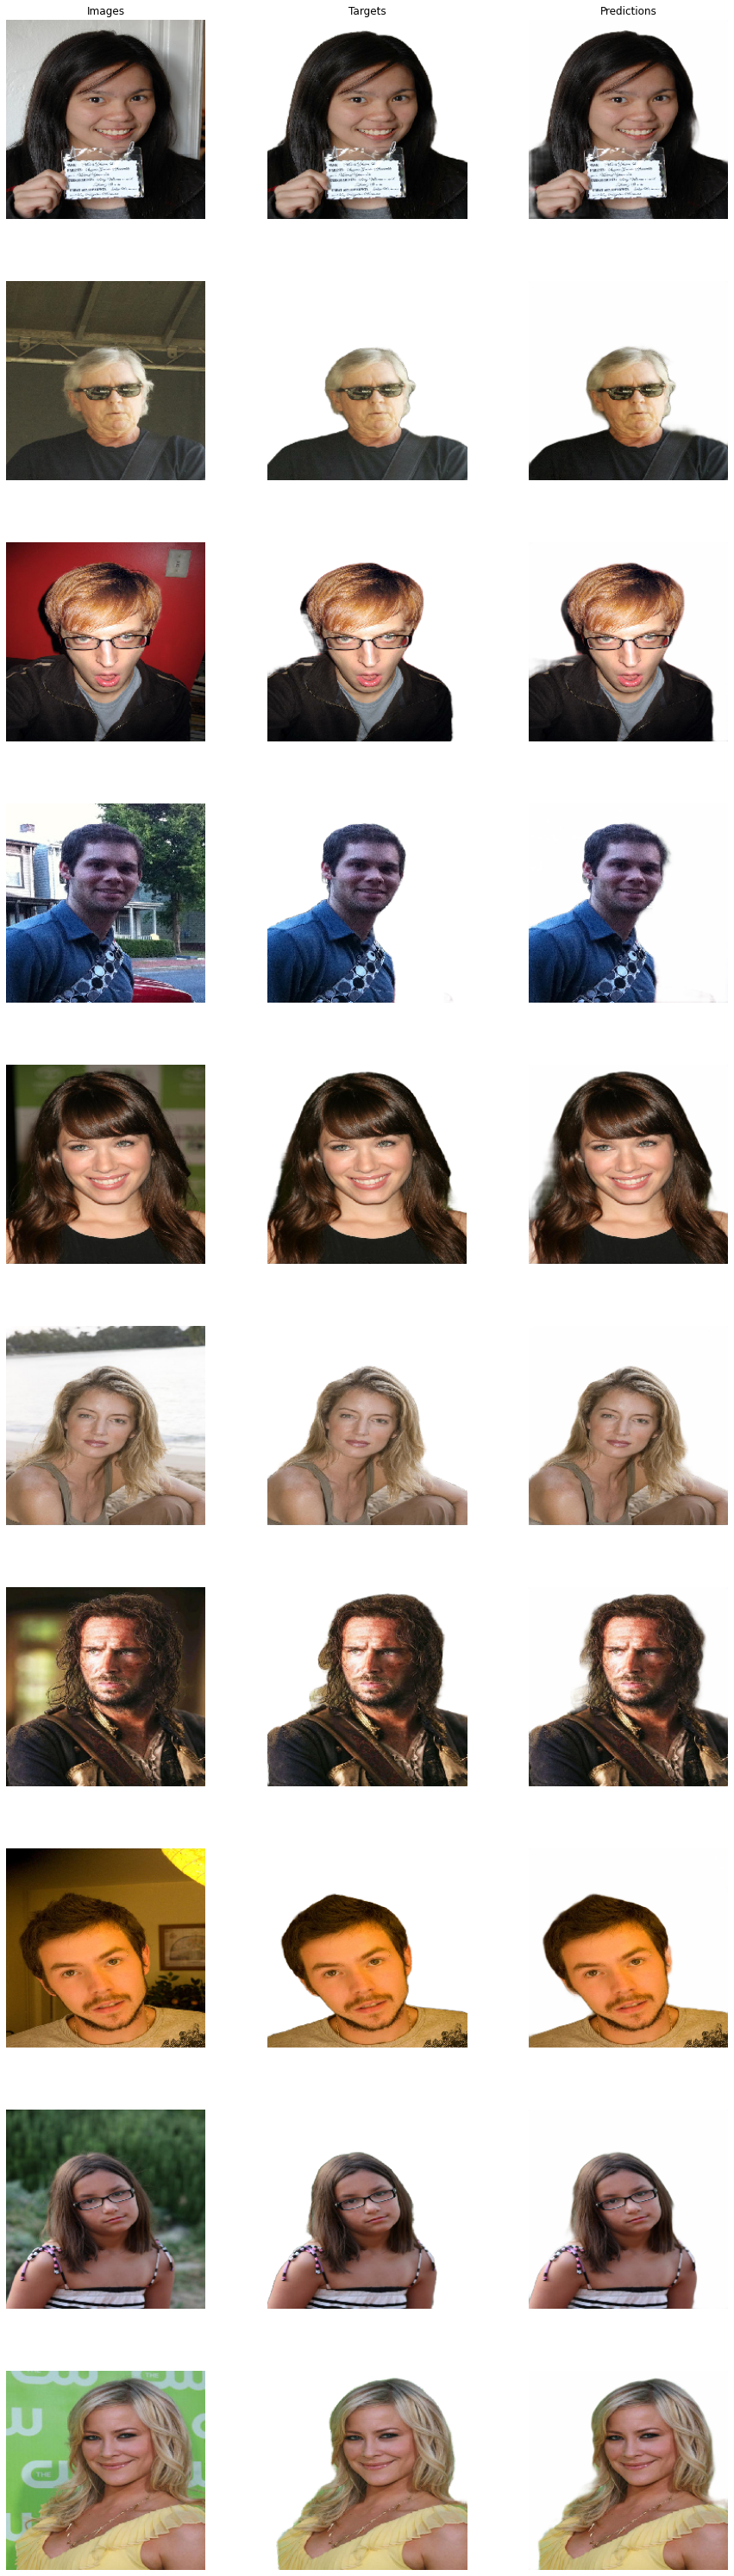

In [ ]:
plot_results(10)

Pretty good results! Particularly taking into account that these images come from the test set. Because it is able to generalize, our model even performs slightly better than the actual targets in some examples.

Let's calculate the intersection over union (IoU) metric on the test data:

In [ ]:
# return the intersection over union for one image
def get_intersection_over_union(y_true, y_pred, target_size=(224,224,1)):

  y_true, y_pred = np.round(y_true/255), np.round(y_pred) # the prediction is already in the [0,1] range

  intersection = 0
  union = 0

  for i in range(target_size[0]):
    for j in range(target_size[1]):
      
      if y_true[i,j]==1 and y_pred[i,j]==1:
        intersection +=1

      if y_true[i,j]==1 or y_pred[i,j]==1:
        union += 1
      
  return intersection/union

In [ ]:
# return the average intersection over union for a set of images
def get_avg_iou(path_split, target_size=(224,224,1)):
  total_iou = 0
  for path in path_split:
    pred = get_predictions(test_path)
    target = get_target(test_path, target_size=target_size)
    target = np.expand_dims(target, axis=-1)

    iou = get_intersection_over_union(target, pred, target_size=target_size)

    total_iou += iou

  average_iou = total_iou / (len(path_split))

  return average_iou

In [ ]:
test_avg_iou = get_avg_iou(test_paths)

In [ ]:
print("Average intersection over union on the test set: {:.4}".format(test_avg_iou))

Average intersection over union on the test set: 0.994


**We got an IoU of 0.994 on the test set**, which is a very good performance. But as I said before, the model can only be as good as the data fed to it, so it would be unreasonable to expect it to work perfectly if the data is not perfectly labelled. 

You can try the algorithm yourself at:
https://share.streamlit.io/javiergarciamolina/selfie-background-removal/main/background-removal-app.py

Please take into account that the model was trained on mid-upper body selfies, with only one person in the picture, relatively near from the camera and with a high contrast with the background.

**How could we improve this algorithm?**


1.   Getting more and better labelled data.
2.   Getting different kinds of photos (not only mid-upper body selfies).
3.   After getting more data, training more complex models and using ensemble-learning.

